In [13]:
%%HTML
<div align='right'>
<script>
    code_show=true;
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
    </div>

## TITAN storm tracks

The storms are identified by “complex track” and “simple track” numbers.  Simple tracks have no “splits” or “mergers”.  Complex tracks consist of all tracks that are “connected” over the course of the event.  The files are organized chronologically by “complex track”.  The complex track number is in the second column and the simple track number is in the third column.  The first column contains the number of distinct “simple tracks” in the complex track.  The numbering of simple tracks is chronological.  The convention is that the complex track number and the simple track number are the same for the first simple track in the complex track.  Thus, complex track numbers do not necessarily have a unit increase from one complex track number to the next.  Time is given by Year, Month, Day, Hour, Min, Sec.  There are several representations of location.  Probably the best to work with are the Reflectivity Centroid Location (ReflCentroidLat and ReflCentroidLon in degrees ); we’ll also look at the Envelope centroid locations.  Useful representations of size and orientation are EnvelopeArea, EnvelopeOrientation, EnvelopeMajorRadius, EnvelopeMinorRadius.  “Convective Intensity” variables include Top, MaxDBZ and HtOfMaxDBZ.  “Cloud slope” is given by TiltAngle and TiltOrientation (lightning may be concentrated in the downslope portion of the cloud).  Motion is given either by Speed and Dirn or U and V.  Area > xx dBZ may be useful in summarizing time variation of aggregate storm properties.  Time rate of change variables include Dtop/Dt, DVolume/Dt and DdBZMax/Dt.

Some simple first comparisons to CG lightning:

 - map of [all storm locations](#Storm-locations) over terrain
 - map of storm locations with [Tops greater than 10 km](#Tops>10)
 - box plot of [storm speed](#Storm-speed)
 - [direction](#Direction) plot for all storm elements

## Combining with lightning analyses

The next step in analyzing the titan output is to compare it with the outputs from features finding in the lightning

In [1]:
import pandas as pd
from pointprocess import *
from lightning_setup import *
from titan import *
from cartopy.io.img_tiles import StamenTerrain

%matplotlib inline

## Storm locations
In this first example the storm we are looking at is 2010-07-20

In [3]:
# the first thing I did was manually get rid of those last 3 rows of un-columned data
c = Region(city=cities['cedar'])
c.define_grid()
storm = '2010-07-20'

fname = '../../lightning/'+storm+'.txt'
df = read_TITAN(fname)

features = pd.HDFStore('cedar/features.h5')
p = features['features_1km5min_thresh01_sigma3_minarea4_const5_buffered_{storm}'.format(storm=storm)]
features.close()

ft = Features(p[df.index[0]:df.index[-1],:,:])
df_light = ft.titanize()

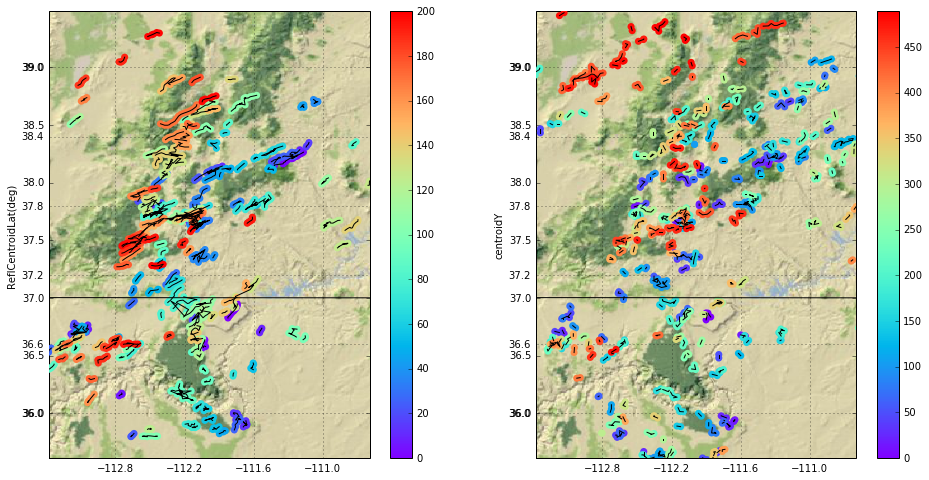

In [6]:
plt.figure(figsize=(16, 8))

ax1 = background(plt.subplot(121, projection=ccrs.PlateCarree()))
ax1.add_image(StamenTerrain(), 7)
ax1 = feature_locations(df, lat='ReflCentroidLat(deg)', lon='ReflCentroidLon(deg)', ax=ax1, paths=True)
extent = ax1.get_extent()

ax2 = background(plt.subplot(122, projection=ccrs.PlateCarree()))
ax2.add_image(StamenTerrain(), 7)
ax2 = feature_locations(df_light, lat='centroidY' ,lon='centroidX', paths=True, ax=ax2)
ax2.set_extent(extent)

## Tops>10
This analysis is only valid for the TITAN

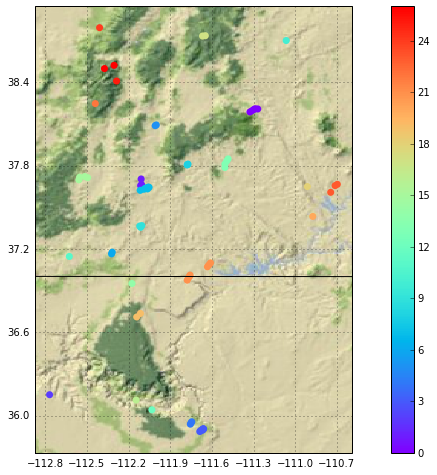

In [5]:
feature_locations(df[df['Top(km)']>10], lat='ReflCentroidLat(deg)', lon='ReflCentroidLon(deg)');

## Storm speed and direction
This one is a little tricky because at initiation the direction is set to zero, so we first need to get rid of all the zeros. Luckily we know that there are no actual zero values because 360 is included in the possible directions

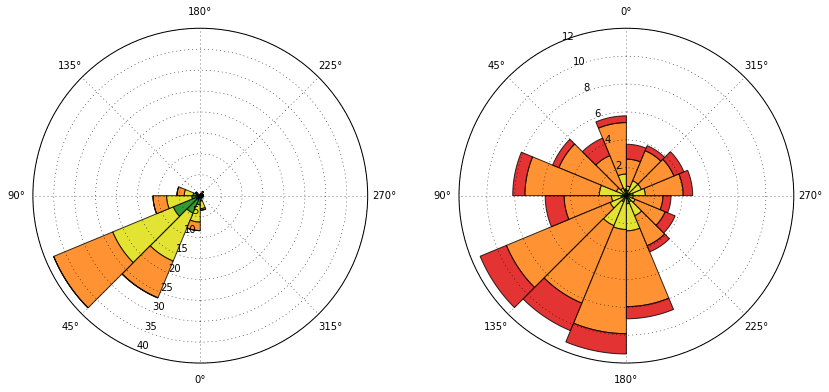

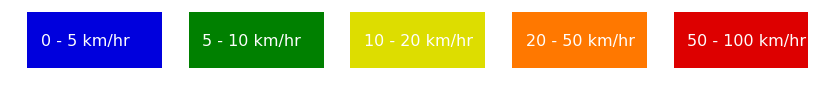

In [4]:
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(121, polar=True)
windrose(df, ax=ax1, N=16)

ax2 = plt.subplot(122, polar=True)
ft.windrose(ax=ax2, N=16);

windrose_cbar(plt.figure(figsize=(14,1)));

If you don't like typing and wasting space

In [5]:
def summary(storm):
    df, ft, df_light = read_storm(storm)
    plot_storm(df, ft, df_light)
    return(df, ft, df_light)

In [6]:
def read_storm(storm):
    fname = '../../lightning/'+storm+'.txt'
    df = read_TITAN(fname)

    features = pd.HDFStore('./notebooks/cedar/features.h5')
    p = features['features_1km5min_thresh01_sigma3_minarea4_const5_buffered_{storm}'.format(storm=storm)]
    features.close()

    ft = Features(p[df.index[0]:df.index[-1],:,:])
    df_light = ft.titanize()

    return(df, ft, df_light)

In [7]:
def plot_storm(df, ft, df_light):
    ydif =df['ReflCentroidLat(deg)'].max() - df['ReflCentroidLat(deg)'].min()
    xdif = df['ReflCentroidLon(deg)'].max() - df['ReflCentroidLon(deg)'].min()    

    plt.figure(figsize=(16, 6*ydif/xdif))

    ax1 = background(plt.subplot(121, projection=ccrs.PlateCarree()))
    ax1.add_image(StamenTerrain(), 7)
    ax1 = feature_locations(df, ax=ax1, lat='ReflCentroidLat(deg)', lon='ReflCentroidLon(deg)', paths=True)
    extent = ax1.get_extent()

    ax2 = background(plt.subplot(122, projection=ccrs.PlateCarree()))
    ax2.add_image(StamenTerrain(), 7)
    ax2 = feature_locations(df_light, lat='centroidY' ,lon='centroidX', paths=True, ax=ax2)
    ax2.set_extent(extent)

    plt.figure(figsize=(16, 4))
    ax1 = plt.subplot(131, polar=True)
    windrose(df, ax=ax1, N=16)

    ax2 = plt.subplot(132, polar=True)
    ft.windrose(ax=ax2, N=16);

    speed = ft.p[:,:,'Centroid Distance'].stack()*100*12
    speed.name = 'speed'
    ax3 = plt.subplot(133)
    ax3.boxplot([df['Speed(km/hr)'], speed], labels=['Radar', 'Lightning'])
    
    windrose_cbar(plt.figure(figsize=(10,1)));

## 2011-08-21

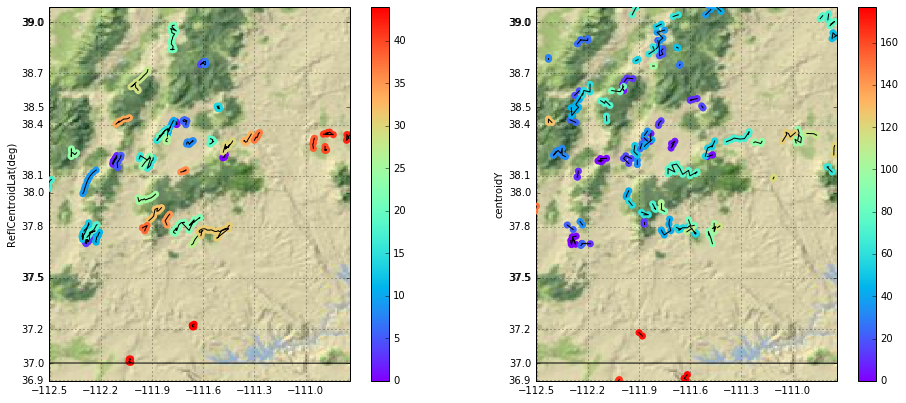

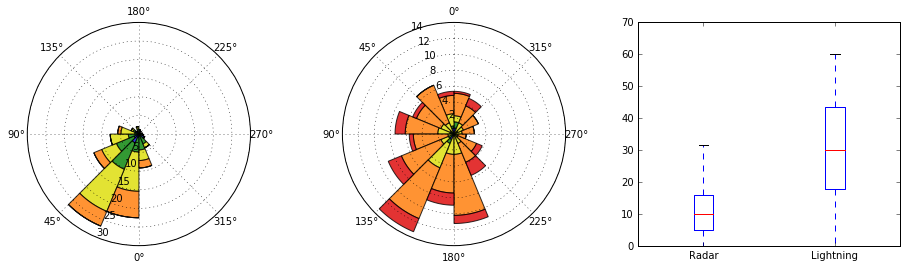

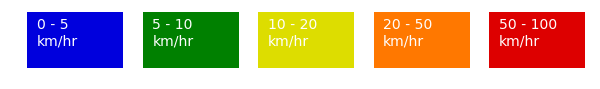

In [8]:
df1, ft1, df_light1 = summary('2011-08-21')

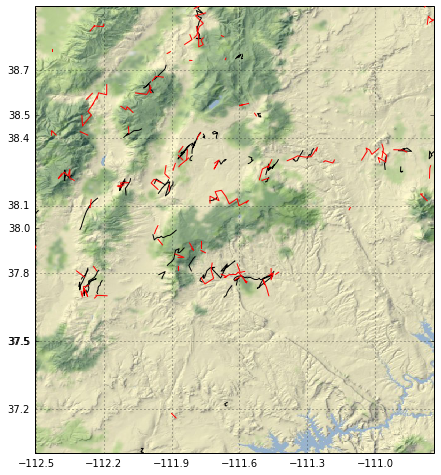

In [20]:
ax = feature_locations(df1, paths=True, features=False, zoom=9)
extent = ax.get_extent()
feature_locations(df_light1, lat='centroidY' ,lon='centroidX', paths=True, features=False, ax=ax, c='r');
ax.set_extent(extent)

## 2012-08-19

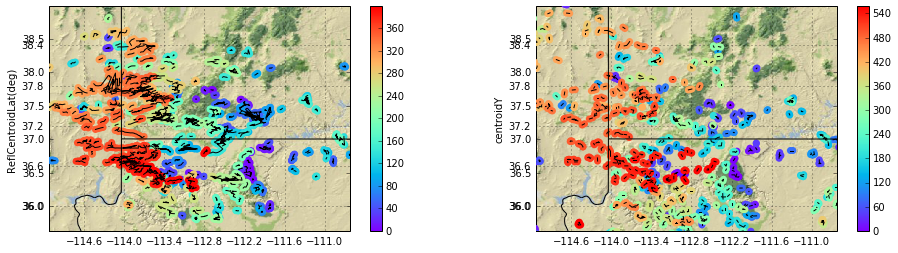

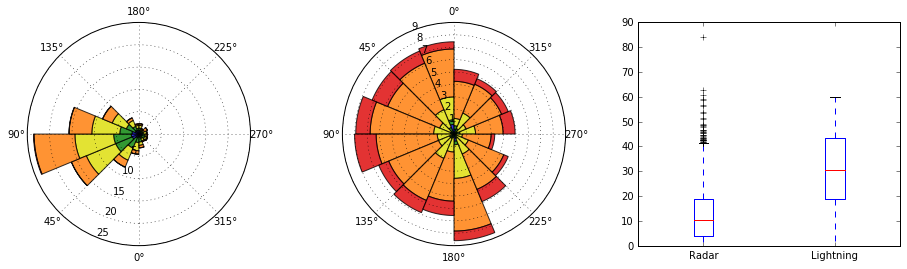

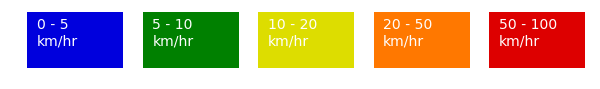

In [9]:
df2, ft2, df_light2 = summary('2012-08-19')

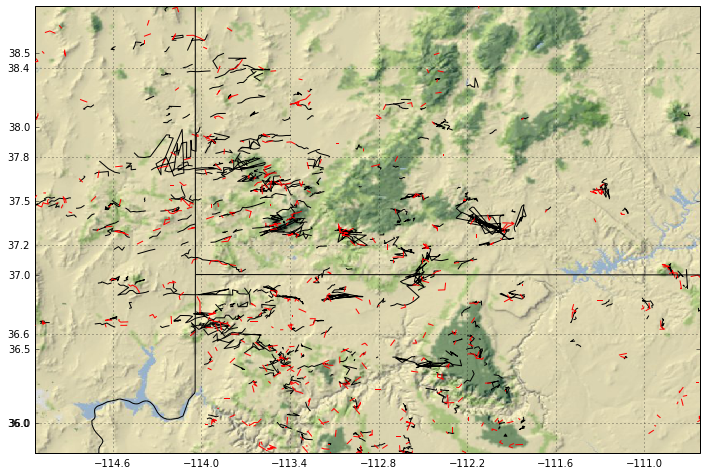

In [19]:
ax = feature_locations(df2, paths=True, features=False, zoom=8)
extent = ax.get_extent()
feature_locations(df_light2, lat='centroidY' ,lon='centroidX', paths=True, features=False, ax=ax, c='r');
ax.set_extent(extent)

## 2013-07-12

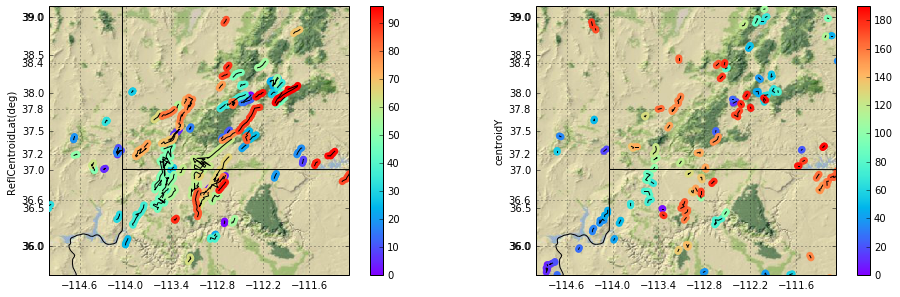

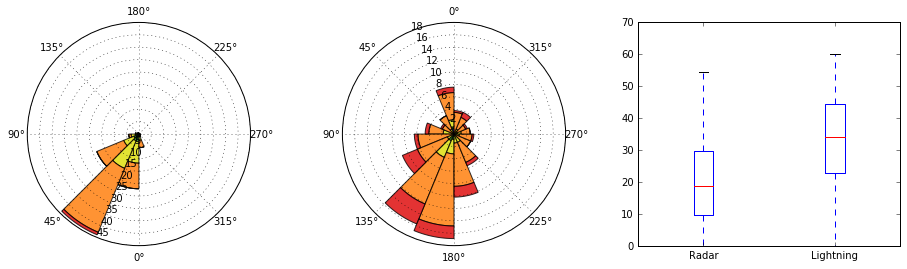

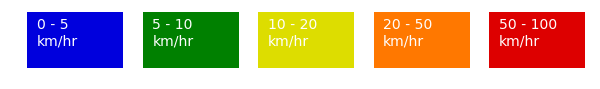

In [10]:
df3, ft3, df_light3 = summary('2013-07-12')

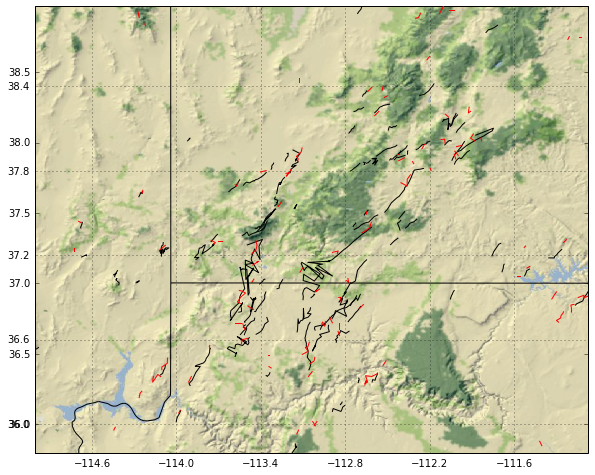

In [18]:
ax = feature_locations(df3, paths=True, features=False, zoom=8)
extent = ax.get_extent()
feature_locations(df_light3, lat='centroidY' ,lon='centroidX', paths=True, features=False, ax=ax, c='r');
ax.set_extent(extent)